# Assignment-6: Machine Learning on Text

**CommonLit Readability Prize**

Can machine learning identify the appropriate reading level of a passage of text, and help inspire learning? Reading is an essential skill for academic success. When students have access to engaging passages offering the right level of challenge, they naturally develop reading skills.


In this competition, we're predicting the reading ease of excerpts from literature. We've provided excerpts from several time periods and a wide range of reading ease scores. Note that the test set includes a slightly larger proportion of modern texts (the type of texts we want to generalize to) than the training set

In [46]:
import pandas as pd
import numpy as np
import os
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
from tqdm import tqdm

## Import Data

In [30]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [32]:
train.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


## EDA

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
import plotly.figure_factory as ff

from plotly import graph_objs as go
from plotly.subplots import make_subplots
from scipy import stats
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [37]:
def plot_graphs(df,feature):
    (osm, osr), (slope, intercept, r) = stats.probplot(df[feature], plot=None)
    fig = make_subplots(
    rows=1, cols=2,

    subplot_titles=(
        "Quantile-Quantile Plot of " + feature,
        "Distribution Plot of " + feature
    )
    )


    fig.add_trace(go.Scatter(
    x=osm,
    y=slope*osm + intercept,
    mode='lines',
    line={
        'color': '#c81515',
        'width': 2.5
    }

    ), row=1, col=1)
    fig.add_trace(go.Scatter(
    x=osm,
    y=osr,
    mode='markers',
    marker={
        'color': '#496595'
    }
    ), row=1, col=1)
    fig1 = ff.create_distplot([df[feature]],['target'], 
                         bin_size=.05, show_rug=False)
    mean_value = df[feature].mean()
    median_value = df[feature].median()

    fig.add_trace(go.Scatter(
    fig1['data'][1],
    line=dict(

    width=1.5,
    ),
    fill='tozeroy'
    ),row=1,col=2)
    fig.add_annotation(
    yref="y domain",
    x=mean_value,
    y=0.5,
    axref="x",
    ayref="y domain",
    ax=mean_value + 0.2*mean_value,
    ay=0.1,
    text=f"<span>{feature.capitalize()} mean</span>= {round(mean_value,3)}",
    row=1,col=2)
    fig.add_annotation(
    yref="y domain",
    x=median_value,
    y=0.3,
    axref="x",
    ayref="y domain",
    ax=median_value + 0.2*median_value,
    ay=0.2,
    text=f"<span>{feature.capitalize()} median</span>= {round(median_value,3)}",
    row=1,col=2)
    fig.add_vline(
    x=mean_value, 
    line_width=2, 
    line_dash="dash",row=1,col=2
    )
    fig.add_vline(
    x=median_value, 
    line_width=2,line_dash="dash",line_color='red' ,row=1,col=2)

    fig.update_layout(showlegend=False)
    fig.show()

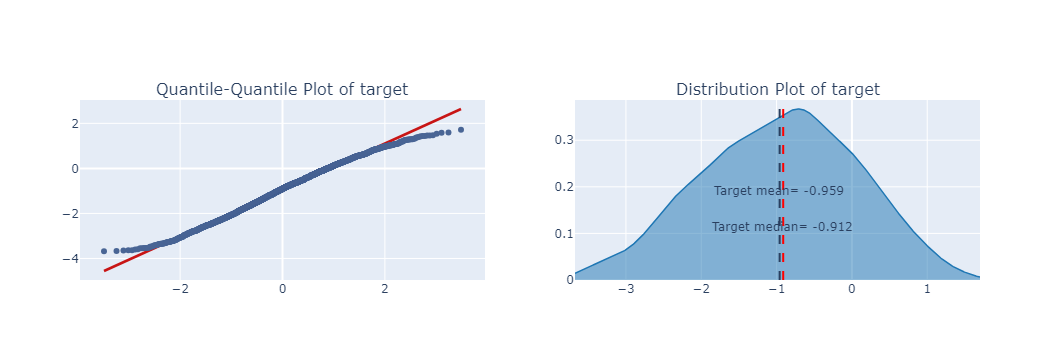

In [41]:
plot_graphs(train,'target')

## Processing Word2Vec

In [52]:
!python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.3 MB/s eta 0:00:000:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [53]:
nlp = spacy.load('en_core_web_sm')
with nlp.disable_pipes():
    train_vec = np.array([nlp(text).vector for text in tqdm(train.excerpt)])

100%|██████████| 2834/2834 [01:51<00:00, 25.45it/s]


In [58]:
nlp(train.excerpt[0]).vector.shape

(96,)

In [60]:
with nlp.disable_pipes():
    test_vec = np.array([nlp(text).vector for text in tqdm(test.excerpt)])

100%|██████████| 7/7 [00:00<00:00, 28.23it/s]


In [62]:
y = train["target"].values

In [64]:
train_vec.shape, test_vec.shape

((2834, 96), (7, 96))

In [66]:
train_vec

array([[ 0.14348806, -0.06067474, -0.11682414, ...,  0.25737756,
        -0.12613346, -0.04063801],
       [-0.10193302, -0.2428944 , -0.07193365, ...,  0.18682061,
        -0.36229292, -0.05612446],
       [-0.00941291, -0.17015815, -0.13795292, ...,  0.1518357 ,
        -0.17794962,  0.0919906 ],
       ...,
       [ 0.04863822, -0.20744365, -0.02862335, ...,  0.28094938,
        -0.30165645,  0.01651077],
       [ 0.03944096, -0.1683138 , -0.08482405, ...,  0.20194638,
        -0.26816624,  0.06903987],
       [ 0.0006966 , -0.05997281, -0.22813824, ...,  0.29362214,
        -0.06719694,  0.06786428]], dtype=float32)

## Training and Prediction

In [69]:
NFOLDS = 10
skf = KFold(n_splits=NFOLDS)
folds = list(skf.split(train_vec))

In [71]:
train_vec[folds[5][0]].shape

(2551, 96)

In [73]:
folds[4][0]

array([   0,    1,    2, ..., 2831, 2832, 2833])

In [75]:
oof = np.zeros(y.shape)
pred = np.zeros((test_vec.shape[0],))
for idx in range(NFOLDS):
    print("FOLD: ", idx + 1)
    tr_idx, val_idx = folds[idx]
    reg = Ridge()
    #reg = LinearRegression()
    reg.fit(train_vec[tr_idx], y[tr_idx])
    oof[val_idx] =reg.predict(train_vec[val_idx])
    pred += reg.predict(test_vec) / NFOLDS

mse = mean_squared_error(y, oof, squared=False)
print("OOF MSE:",mse)

FOLD:  1
FOLD:  2
FOLD:  3
FOLD:  4
FOLD:  5
FOLD:  6
FOLD:  7
FOLD:  8
FOLD:  9
FOLD:  10
OOF MSE: 0.8128557436266607


## Regression Functions

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [80]:
def algo_test(x,y):
        L=LinearRegression()
        R=Ridge()
        Lass=Lasso()
        E=ElasticNet()
        ETR=ExtraTreeRegressor()
        GBR=GradientBoostingRegressor()
        kn=KNeighborsRegressor()
        dt=DecisionTreeRegressor()
        xgb=XGBRegressor()
        
        algos=[L,R,Lass,E,ETR,GBR,kn,dt,xgb]
        algo_names=['Linear','Ridge','Lasso','ElasticNet','Extra Tree','Gradient Boosting','KNeighborsRegressor','Decision Tree','XGBRegressor']
        
        x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.2,random_state=42)
        
        r_squared= []
        rmse= []
        mae= []
        
        result=pd.DataFrame(columns=['R_Squared','RMSE','MAE'],index=algo_names)
        
        for algo in algos:
            p=algo.fit(x_train,y_train).predict(x_test)
            r_squared.append(r2_score(y_test,p))
            rmse.append(mean_squared_error(y_test,p)**.5)
            mae.append(mean_absolute_error(y_test,p))
        
        result.R_Squared=r_squared
        result.RMSE=rmse
        result.MAE=mae
        
        rtable=result.sort_values('R_Squared',ascending=False)
        return rtable

In [82]:
algo_test(train_vec, y)

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning:

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


,R_Squared,RMSE,MAE
Gradient Boosting,0.422771,0.777438,0.633148
Ridge,0.414485,0.782998,0.633202
Linear,0.411371,0.785077,0.636001
XGBRegressor,0.368443,0.813201,0.658099
KNeighborsRegressor,0.326865,0.839542,0.680455
Lasso,-0.000616,1.023588,0.831197
ElasticNet,-0.000616,1.023588,0.831197
Decision Tree,-0.250046,1.144075,0.900668
Extra Tree,-0.336087,1.182793,0.940966


## SUBMISSION

In [89]:
sub = test[["id"]].copy()
sub["target"] = pred

In [91]:
sub.head()

,id,target
0,c0f722661,-1.023331
1,f0953f0a5,-0.441325
2,0df072751,-0.423838
3,04caf4e0c,-1.865003
4,0e63f8bea,-1.162123


In [93]:
sub.to_csv("submission.csv", index=False)